# pbh

> A module to model and calculate the properties of primordial black holes (PBHs), such as density, mass, distance, and velocity distribution.

In [ ]:
#| default_exp pbh

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from LensCalcPy.parameters import *
from LensCalcPy.utils import *

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import nquad

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#| export
class Pbh:
    """A class to represent a PBH population"""

    def __init__(self,
                m_pbh: float, # PBH mass in solar masses
                f_dm: float # PBH fraction of the DM density
                ):
        """
        Initialize the PBH population
        """
        self.m_pbh = m_pbh
        if f_dm < 0 or f_dm > 1:
            raise ValueError("f_dm must be between 0 and 1")
        self.f_dm = f_dm
    
    def __str__(self) -> str:
        return f"PBH population with m_pbh={self.m_pbh} and f_dm={self.f_dm}"
    __repr__ = __str__

    def density(self, d: float) -> float:
        rmw = dist_mw(d)
        rm31 = dist_m31(d)
        return self.f_dm *(density_mw(rmw) + density_m31(rm31))
    
    def differential_rate_integrand_mw(self, umin, d, t):
        r = dist_mw(d)
        return 2 * (1 / (ut**2 - umin**2)**0.5 *
                density_mw(r) / (self.m_pbh * velocity_dispersion_mw(r)**2) *
                velocity_radial(d, self.m_pbh, umin, t * htosec)**4 * (htosec / kpctokm)**2 *
                np.exp(-(velocity_radial(d, self.m_pbh, umin, t * htosec)**2 / velocity_dispersion_mw(r)**2)))
    
    def differential_rate_integrand_m31(self, umin, d, t):
        r = dist_m31(d)
        return 2 * (1 / (ut**2 - umin**2)**0.5 *
                density_m31(r) / (self.m_pbh * velocity_dispersion_m31(r)**2) *
                velocity_radial(d, self.m_pbh, umin, t * htosec)**4 * (htosec / kpctokm)**2 *
                np.exp(-(velocity_radial(d, self.m_pbh, umin, t * htosec)**2 / velocity_dispersion_m31(r)**2)))
    
    def differential_rate_integrand(self, umin, d, t):
        return self.differential_rate_integrand_mw(umin, d, t) + self.differential_rate_integrand_m31(umin, d, t)
    
    def differential_rate_mw(self, t):
        umin_bounds = [0, ut*0.999]
        d_bounds = [0, ds*0.999]

        result, error = nquad(self.differential_rate_integrand_mw, [umin_bounds, d_bounds], args=[t])

        return result
    
    def differential_rate_m31(self, t):
        umin_bounds = [0, ut*0.999]
        d_bounds = [0, ds*0.999]

        result, error = nquad(self.differential_rate_integrand_m31, [umin_bounds, d_bounds], args=[t])

        return result
    
    def differential_rate(self, t):
        #The integral is a bit sensitive to the bounds, so we have to be careful
        #For m31 there's a singularity at d=ds
        # umin_bounds = [0, ut*0.999]
        # d_bounds = [0, ds*0.999]
        umin_bounds = [0, ut]
        d_bounds = [0, ds]

        result, error = nquad(self.differential_rate_integrand, [umin_bounds, d_bounds], args=[t])

        return result
    
    

In [ ]:
pbh = Pbh(1e-8, 1)

In [ ]:
ts = np.logspace(-2,1,50)
result_mw = [pbh.differential_rate_mw(t) for t in ts]
result_m31 = [pbh.differential_rate_m31(t) for t in ts]

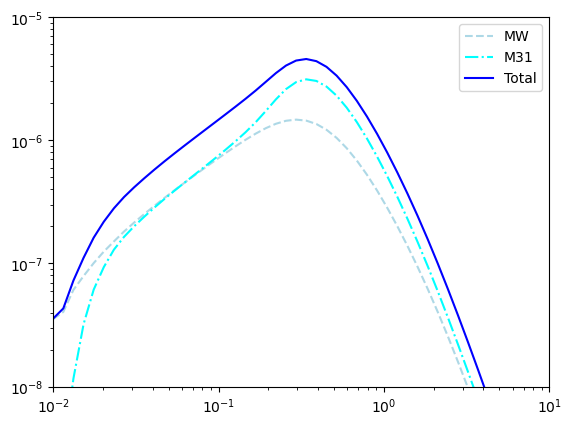

In [ ]:
plt.loglog(ts, result_mw, label="MW", color="lightblue", linestyle="--")
plt.loglog(ts, result_m31, label="M31", color="cyan", linestyle="-.")
plt.loglog(ts, np.array(result_mw) + np.array(result_m31), label="Total", color="blue")
plt.xlim(1e-2, 1e1)
plt.ylim(1e-8, 1e-5)
plt.legend()
plt.show()

/var/folders/qd/09mj47cx551c65glw6y47d6r0000gn/T/ipykernel_95979/2657340018.py:35: RuntimeWarning: divide by zero encountered in double_scalars
  return 2 * (1 / (ut**2 - umin**2)**0.5 *
/var/folders/qd/09mj47cx551c65glw6y47d6r0000gn/T/ipykernel_95979/2657340018.py:35: RuntimeWarning: invalid value encountered in double_scalars
  return 2 * (1 / (ut**2 - umin**2)**0.5 *


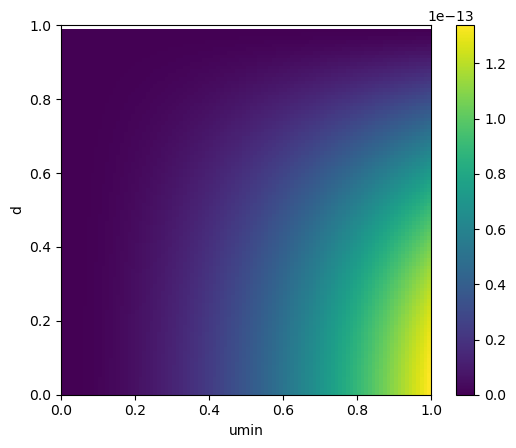

In [ ]:
umin_bounds = [0, 1]
d_bounds = [0,1]

umin_values = np.linspace(umin_bounds[0], umin_bounds[1], 100)
d_values = np.linspace(d_bounds[0], d_bounds[1], 100)

# Plot for a fixed t value
t = 0.5

Z = np.zeros((100, 100))

for i in range(100):
    for j in range(100):
        Z[i, j] = pbh.differential_rate_integrand_m31(umin_values[i], d_values[j], t)

plt.imshow(Z, extent=(umin_values[0], umin_values[-1], d_values[0], d_values[-1]), origin='lower')
plt.colorbar()
plt.xlabel('umin')
plt.ylabel('d')
plt.show()


In [ ]:
ts = np.logspace(-2, 3, 100)
pbhs = [Pbh(10**(i), 1) for i in np.linspace(-5, -3, 3)]
result = np.zeros((len(pbhs), len(ts)))
for i, pbh in enumerate(pbhs):
    for j, t in enumerate(ts):
        result[i, j] = pbh.differential_rate(t)
    

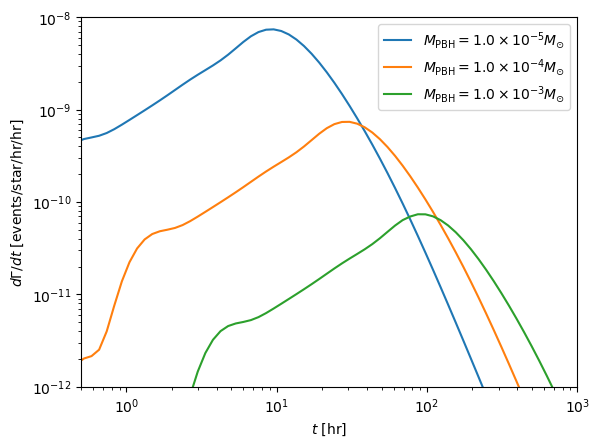

In [ ]:
for i, pbh in enumerate(pbhs):
    # plt.loglog(ts, result[i], label=r"$M_{\rm{PBH}} = " + str(pbh.m_pbh) + "M_{\odot}$")
    plt.loglog(ts, result[i], label=r"$M_{\rm{PBH}} = $" + scientific_format(pbh.m_pbh,0) + "$M_{\odot}$")


plt.xlabel(r"$t$ [hr]")
plt.ylabel(r"$d\Gamma/dt$ [events/star/hr/hr]")
plt.xlim(5e-1, 1e3)
plt.ylim(1e-12, 1e-8)

plt.legend()
plt.show()


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()